In [1]:
import pickle
import numpy as np
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
def load_problem(file_name = "data.pickle"):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return data["x_train"], data["y_train"],data["x_test"], data["y_test"]
base_dir = "Data/"
filename = "save.pickle"
x_train, y_train, x_test,y_test = load_problem(base_dir+filename)
total_row, n_features = x_train.shape

label2one = {'B':0,'S':1,'X':2}
one2label = {0:'B', 1:'S', 2:'X'}
vfunc = np.vectorize(lambda x:label2one[x])

# y_train = vfunc(y_train)
y_test = vfunc(y_test)

In [2]:
def data_gen(dx, dy, batch_size=100):
    idx = 0
    while True:
        if idx*batch_size >= dx.shape[0]:
            return
        elif (idx+1)*batch_size > dx.shape[0]:
            yield dx[idx*batch_size:,:], dy[idx*batch_size:]
        else:
            yield dx[idx*batch_size:(idx+1)*batch_size,:], dy[idx*batch_size:(idx+1)*batch_size]
        idx += 1
def accuracy(pred, y):
    pred = np.argmax(pred,axis=1)
    if y is None:
        return 0
    return np.sum(pred == y) / y.shape[0]
def criterion(pred, y):
    s = 0
    for i in range(pred.shape[0]):
        s -= np.log(pred[i,y[i]])
    return s/y.shape[0]

In [3]:
vdx = Variable(torch.from_numpy(x_test.A.astype(np.float32)))
vdy = Variable(torch.from_numpy(y_test)).long()

In [ ]:
class ResNet(nn.Module):
    def __init__(self, in_dim):
        super(ResNet, self).__init__()

        self.lin1 = nn.Linear(in_dim, in_dim)
        self.lin2 = nn.Linear(in_dim, in_dim)
    def forward(self, x):
        output = F.relu(self.lin1(x))
        return self.lin2(output) + x

class Fcc(nn.Module):
    def __init__(self, D_in):
        super(Fcc, self).__init__()
        p = 0.3
        res_dim=1024

        self.lin1 = nn.Linear(D_in, 2048)
        # self.drop2 = nn.Dropout(0.5)
        # self.lin9 = nn.Linear(2048,2048)
        # self.drop8 = nn.Dropout(0.3)
        self.res2 = ResNet(2048)
        self.drop3 = nn.Dropout(0.4)
        self.res3 = ResNet(2048)
        self.drop4 = nn.Dropout(0.25)

        self.lin3 = nn.Linear(2048, 1024)

        self.res4 = ResNet(1024)
        self.drop5 = nn.Dropout(0.15)
        self.res5 = ResNet(1024)
        self.drop6 = nn.Dropout(0.15)
        self.lin6 = nn.Linear(1024, 512)
        # self.res6 = ResNet(1024)
        self.drop7 = nn.Dropout(0.15)
        self.res7 = ResNet(512)
        self.lin7 = nn.Linear(512,256)
        # self.res8 = ResNet(256)
        self.lin8 = nn.Linear(256,3)
    
    def forward(self, x):

        #output = self.drop1(output)
        output = self.lin1(x)
        output = F.relu(output)
        
        # output = self.drop2(output)
        
        # output = F.relu(self.lin9(output))
        # output = self.drop8(output)
        
        output = self.res2(output)
        output = F.relu(output)
        
        output = self.drop3(output)
        output = self.res3(output)
        output = F.relu(output)
        
        output = self.drop4(output)
        output = F.relu(self.lin3(output))

        output = self.res4(output)
        output = F.relu(output)

        output = self.drop5(output)
        output = self.res5(output)
        output = F.relu(output)

        output = self.drop6(output)
        output = self.lin6(output)
        output = F.relu(output)

        # output = self.res6(output)
        # output = F.relu(output)
        output = self.drop7(output)
        output = self.res7(output)
        output = F.relu(output)

        output = self.lin7(output)
        output = F.relu(output)

        # output = self.res8(output)
        # output = F.relu(output)

        output = self.lin8(output)
        output = F.log_softmax(output, dim=1)

        return output

In [5]:
model_name = "14-16_17/model_107.out"
# model = Fcc(n_features)
load_data = torch.load(model_name, map_location=lambda storage, loc: storage)

prob = load_data["prob"]
pred = load_data["pred"]

# model.load_state_dict(load_data[""]) 

In [ ]:
model.eval()
bt_size = 4096
# final_prediction = []
prob = []
for dx,dy in data_gen(vdx, vdy, batch_size=bt_size):
    dy_pred = model(dx)
    pred = dy_pred.exp().cpu().data.numpy()
    prob.append(pred)
# final_prediction = np.concatenate(final_prediction)
prob = np.concatenate(prob,axis = 0)
pred = np.argmax(prob,axis=1)

## Features
### features_for_LE_and_OH 
    ["side","p_throws","b_bats","pitch_type"]
### extra_features_for_OH 
    ["inning","ball_strike"]
### Rest 
    ["pitch_count","p_hit_ratio","b_hit_ratio"]

### For test data
    pitch_type is assigned according to the pitch_type distribution regarding the pitcher

Fcc(
  (lin1): Linear(in_features=53, out_features=2048)
  (res2): ResNet(
    (lin1): Linear(in_features=2048, out_features=2048)
    (lin2): Linear(in_features=2048, out_features=2048)
  )
  (drop3): Dropout(p=0.4)
  (res3): ResNet(
    (lin1): Linear(in_features=2048, out_features=2048)
    (lin2): Linear(in_features=2048, out_features=2048)
  )
  (drop4): Dropout(p=0.4)
  (lin3): Linear(in_features=2048, out_features=1024)
  (res4): ResNet(
    (lin1): Linear(in_features=1024, out_features=1024)
    (lin2): Linear(in_features=1024, out_features=1024)
  )
  (drop5): Dropout(p=0.2)
  (res5): ResNet(
    (lin1): Linear(in_features=1024, out_features=1024)
    (lin2): Linear(in_features=1024, out_features=1024)
  )
  (drop6): Dropout(p=0.2)
  (lin6): Linear(in_features=1024, out_features=512)
  (drop7): Dropout(p=0.2)
  (res7): ResNet(
    (lin1): Linear(in_features=512, out_features=512)
    (lin2): Linear(in_features=512, out_features=512)
  )
  (lin7): Linear(in_features=512, out_features=256)
  (lin8): Linear(in_features=256, out_features=3)
)


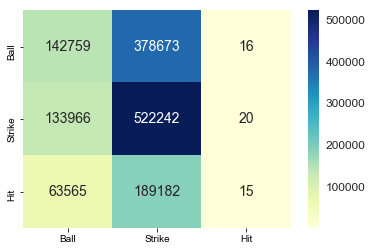

loss:  1.0174077291833825
Accuracy:  0.4649037567514286


In [6]:
from sklearn.metrics import confusion_matrix
from confusion_matrix import generate_confusion_matrix
generate_confusion_matrix(y_test,pred)
# print(confusion_matrix(y_test, pred))
print("loss: ",criterion(prob, y_test))
print("Accuracy: ",accuracy(prob, y_test))